In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# read in all the words
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 24: 'z', 25: 'ó', 26: 'ę', 27: 'ł', 28: 'ń', 29: 'ś', 30: 'ż', 0: '.'}
31


In [ ]:
# build the dataset
block_size = 4

def build_dataset(imiona):  
  X, Y = [], []
  
  for w in imiona:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

Xtr,  Ytr  = build_dataset(imiona[:n1])     # 80%
Xdev, Ydev = build_dataset(imiona[n1:n2])   # 10%
Xte,  Yte  = build_dataset(imiona[n2:])     # 10%

torch.Size([3919, 4]) torch.Size([3919])
torch.Size([510, 4]) torch.Size([510])
torch.Size([480, 4]) torch.Size([480])


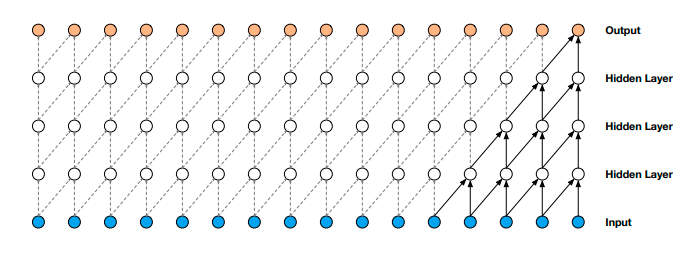

In [ ]:
class Linear:
    def __init__(self, ins, outs, bias = True):
        self.weight = torch.rand((ins,outs), generator = g)
        self.bias = torch.zeros((outs)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.momentum = momentum 
        self.eps = eps
        self.training = True
        #
        self.gamma = torch.ones((dim))
        self.beta = torch.zeros((dim))
        #
        self.rmean = torch.zeros((dim))
        self.rvar = torch.ones((dim))
        
    def __call__(self, x):
            
        if self.training:
          if x.ndim == 2:
            dim = 0
          elif x.ndim == 3:
            dim = (0,1)
          xmean = x.mean(dim, keepdim = True)
          xvar = x.var(dim, keepdim = True)
        else:
            xmean = self.rmean
            xvar = self.rvar
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.rmean = (1 - self.momentum) * self.rmean + self.momentum * xmean
                self.rvar = (1 - self.momentum) * self.rvar + self.momentum * xvar

        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
#embedding layer - A simple lookup table that stores embeddings of a fixed dictionary and size.
#https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
class Embedding:
  def __init__(self, num_embeddings, dim_embeddings):
    self.weight = torch.rand((num_embeddings, dim_embeddings))
  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out
  def parameters(self):
    return [self.weight]
#flatten layer
class FlattenWave:
  def __init__(self, n):
    self.n = n
  def __call__(self, x):
    a,b,c = x.shape
    x = x.view(a,b//self.n ,c * self.n) # taking n words at a time and concatinating them together 
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
# sequential container
#https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
class dilated_conv:
    def __init__(self, k):
        self.k = k
    def __call__(self, x):
        a,b,c= x.shape
        x = x.swapaxes(1,2)
        self.conv1d = nn.Conv1d(c, c//self.k, self.k)
        
        self.out = self.conv1d(x)
        return self.out
        
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = (torch.rand(in_channels, kernel_size))
        #self.bias = (torch.zeros(1))
        
    def corr2d(self, x):
        a,b,c = x.shape
        Y = torch.zeros((a, self.out_channels, c - 1))
        for i in range(a):
            for j in range(c):
                Y[i, i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias   

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (32,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]
model = Sequential([Embedding(vocab_size, 2)])
out = model(Xb)
out.shape, Xb.shape
out = out.swapaxes(1,2)
conv1d = nn.Conv1d(2,1,2)
conv1d(out).shape, conv1d.weight

In [ ]:
g = torch.Generator().manual_seed(43)
dims = 10
n_hidden = 200

model = Sequential([
Embedding(vocab_size, dims),
FlattenWave(2), Linear(   2 * dims  , n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
FlattenWave(2), Linear(   n_hidden * 2 , n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),

 Linear(    n_hidden , vocab_size, bias = False)

 ])
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (32,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(f"""Xb shape : {Xb.shape}""")
for layer in model.layers:
  print(layer.__class__.__name__, tuple(layer.out.shape))

Xb shape : torch.Size([32, 4])
Embedding (32, 4, 10)
FlattenWave (32, 2, 20)
Linear (32, 2, 200)
BatchNorm1d (32, 2, 200)
Tanh (32, 2, 200)
FlattenWave (32, 400)
Linear (32, 200)
BatchNorm1d (32, 200)
Tanh (32, 200)
Linear (32, 31)


      0/  20000: 3.5036
   1000/  20000: 2.5333
   2000/  20000: 2.9661
   3000/  20000: 2.6108
   4000/  20000: 2.8442
   5000/  20000: 2.4351
   6000/  20000: 2.8202
   7000/  20000: 2.4734
   8000/  20000: 2.2348
   9000/  20000: 1.9760
  10000/  20000: 1.9991
  11000/  20000: 1.8016
  12000/  20000: 1.8082
  13000/  20000: 1.7033
  14000/  20000: 1.9386
  15000/  20000: 2.1444
  16000/  20000: 2.2644
  17000/  20000: 1.6094
  18000/  20000: 1.4600
  19000/  20000: 1.9110


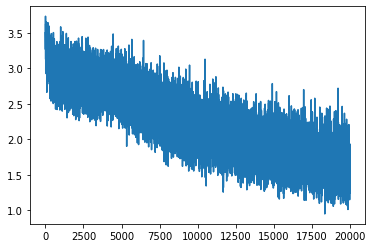

In [ ]:
steps = 20000
batch_size = 32
losses, accuracies = [], []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
   
    #forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    #backward
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 1000 == 0: 
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
plt.plot(np.arange(steps), losses);    

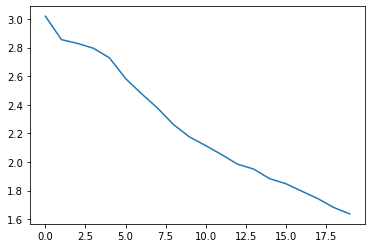

In [ ]:
losses = torch.tensor(losses)
losses = losses.view(-1,1000).mean(1)

plt.plot(losses)

In [ ]:
for layer in model.layers:
    layer.training = False

In [ ]:
with torch.no_grad():
    x = Xte
    logits = model(x)
    loss = F.cross_entropy(logits, Yte)
    print(loss)

tensor(2.1523)


In [ ]:
#sampling from model
for i in range(20):
    out = []
    context = [0] * block_size 
    while True:
        x = torch.tensor([context])
        x = model(x)
        logits = x
        probs = torch.softmax(logits,1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))      

ikon.
jan.
miłol.
konstanna.
potrojer.
manorian.
radoldy.
kubostaw.
jóycy.
terniusz.
mitomił.
lenisława.
oldwina.
sacy.
terh.
jomir.
witolfanna.
mardonoda.
lozian.
konsrynai.


In [ ]:
x = Xtr[[6]]
model = Sequential([Embedding(vocab_size, 2)])
out = model(x)
out.shape
conv1 = nn.Conv1d(2, 1, 2)
out = out.swapaxes(1,2)
conv1(out)

### performance log
* block_size = 3 -> loss: 2.3360
* block_size = 8 -> loss: 2.4742
* wave block_size = 4 ->loss : 2.1523